In [1]:
#以下是对IRIS的分类
from torch.utils.data import Dataset,DataLoader
import torch
import pandas as pd
import random
import numpy as np

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#以下是数据集创建，基本是上一个作业照搬
class IRIS(Dataset):
    def __init__(self):
        raw_data=pd.read_csv('实验数据集/Iris数据集/iris.csv')
        raw_data['Species']=raw_data['Species'].map(self._map_function)
        data=np.array(raw_data[['Sepal.Length','Sepal.Width','Petal.Length','Petal.Width','Species']])
        random.shuffle(data)
        
        points=data[:,:-1]
        label=data[:,-1].reshape(1,-1)
        points=points.astype(float)
        label=label.astype(int)
        points=torch.tensor(points)
        label=torch.tensor(label)
        self.train_set=points[:90].float()
        self.train_label=label[:,:90].int()
        self.test_set=points[90:].float()
        self.test_label=label[:,90:].int()

    def _map_function(self,x):
        if x=='setosa':
            return 0
        elif x=='versicolor':
            return 1
        else:
            return 2
    
    def __len__(self):
        return self.train_set.shape[0]
    
    def __getitem__(self, index):
        return self.train_set[index,:],self.train_label[0,index]
    

In [2]:
#以下是网络创建
import torch.nn as nn
class IRIS_Net(nn.Module):
    def __init__(self,hidden_layer_dims,active_type):
        super(IRIS_Net,self).__init__()
        layer_num=len(hidden_layer_dims)
        layers=[]
        self.hidden_layer_dims=[4]+hidden_layer_dims+[3]
        self.layer_num=layer_num+1

        #添加网络层
        for i in range(self.layer_num):
            layers.append(nn.Linear(self.hidden_layer_dims[i],self.hidden_layer_dims[i+1]))
            if active_type=='relu' and i!=self.layer_num-1:
                layers.append(nn.ReLU())
            elif active_type=='tanh' and i!=self.layer_num-1:
                layers.append(nn.Tanh())
        
        self.layers= nn.Sequential(*layers)
    
    #这里之所以用logits是之前在某门课程中听说先logits与softmax分开比较好
    def forward(self,x):
        logits=self.layers(x)
        return logits

In [3]:
#以下是训练函数
import torch.nn.functional as F
import matplotlib.pyplot as plt

def train(model,epochs,batch_size,data,optimizer):
    dataloader=DataLoader(data,batch_size)
    acc_on_train=[]
    acc_on_test=[]
    loss_all=[]
    for epoch in range(epochs):
        correct_train =0
        correct_test=0
        loss_per_epoch = 0.0

        with torch.no_grad():
            test_example=data.test_set.to(device)
            test_label=data.test_label.to(device)
            logits_on_test=model(test_example)
            pred_on_test=torch.argmax(logits_on_test,-1)
            correct_test=int((pred_on_test== test_label).sum().int().cpu())
            acc_on_test.append(correct_test/test_label.shape[1])

        for batch, (X, y) in enumerate(dataloader):
            X=X.to(device)
            y=y.long().to(device)
            logits=model(X)
            loss=F.cross_entropy(logits,y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_per_epoch+=float(loss.cpu())
            pred_on_train=torch.argmax(logits,-1)
            correct_train += int((pred_on_train== y).sum().int().cpu())
        
        acc_on_train.append(correct_train/data.train_set.shape[0])
        loss_all.append(loss_per_epoch)
    
    plt.plot(range(epochs), acc_on_test, label='accuracy on test set')
    plt.plot(range(epochs), acc_on_train, label='accuracy on train set')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc='best')
    plt.show()

    plt.plot(range(epochs), loss_all, label='loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='best')
    plt.show()


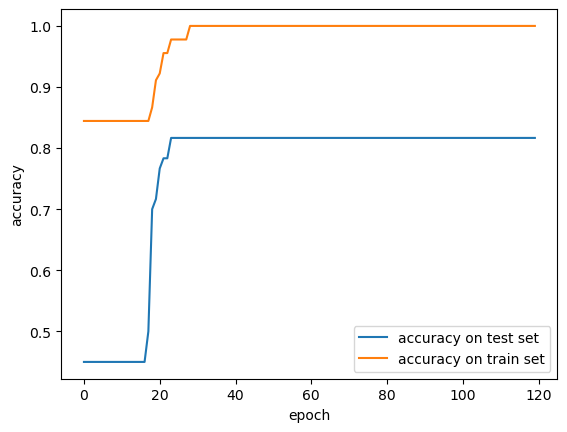

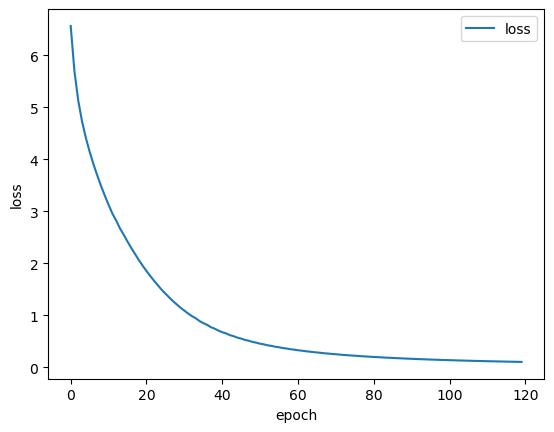

In [4]:
import torch.optim as optim
iris_net=IRIS_Net([4],'relu')
iris_net=iris_net.to(device)
iris_data=IRIS()
optimizer=optim.SGD(iris_net.parameters(),0.01)
train(iris_net,120,10,iris_data,optimizer)

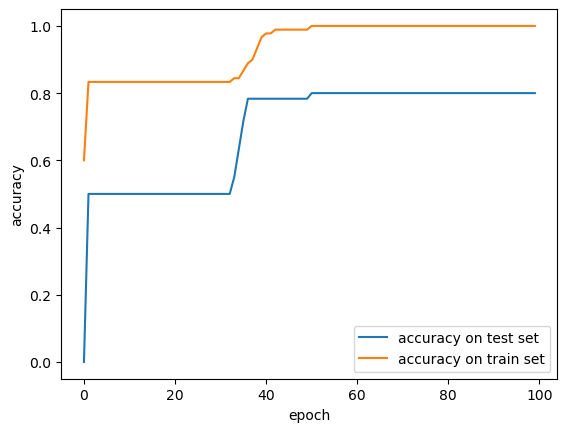

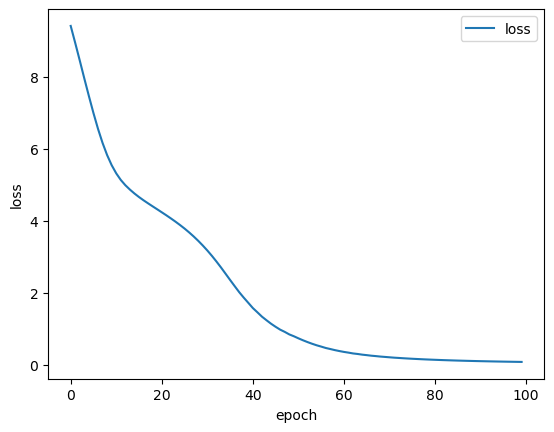

In [5]:
#增加隐藏层数
iris_net1=IRIS_Net([8,16,8],'relu')
iris_net1=iris_net1.to(device)
iris_data=IRIS()
optimizer=optim.SGD(iris_net1.parameters(),0.01)
train(iris_net1,100,10,iris_data,optimizer)

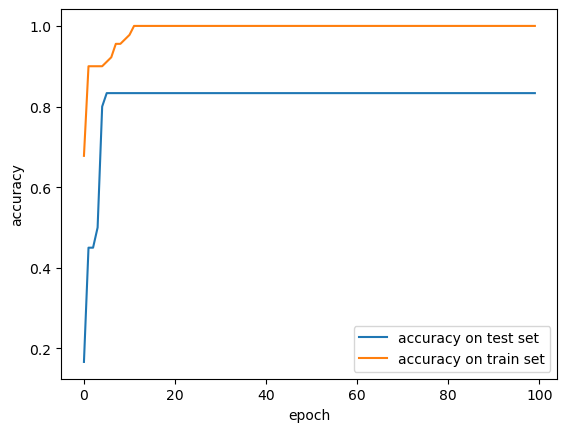

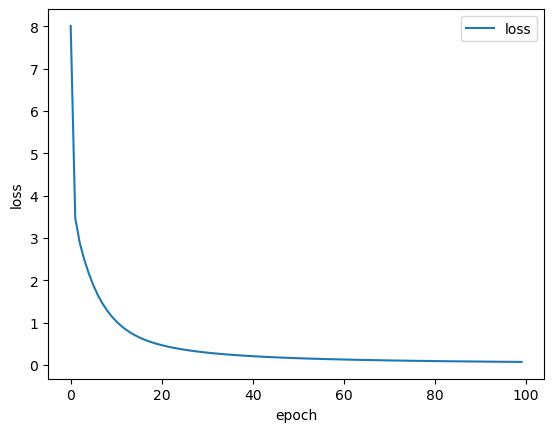

In [6]:
#增加节点
iris_net2=IRIS_Net([64],'relu')
iris_net2=iris_net2.to(device)
iris_data=IRIS()
optimizer=optim.SGD(iris_net2.parameters(),0.01)
train(iris_net2,100,10,iris_data,optimizer)

In [1]:
#改变学习率
iris_net3=IRIS_Net([4],'relu')
iris_net3=iris_net1.to(device)
iris_data=IRIS()
optimizer=optim.SGD(iris_net3.parameters(),0.001)
train(iris_net3,200,10,iris_data,optimizer)

NameError: name 'IRIS_Net' is not defined

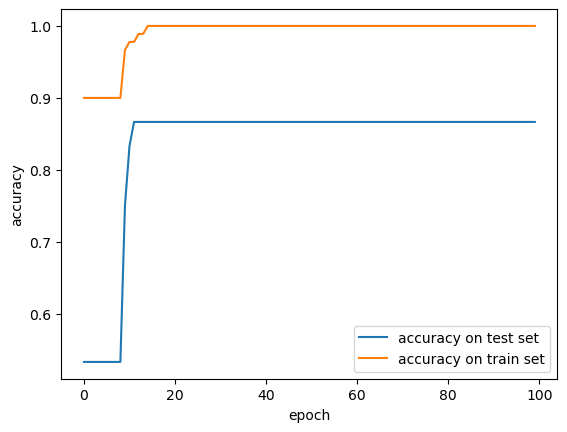

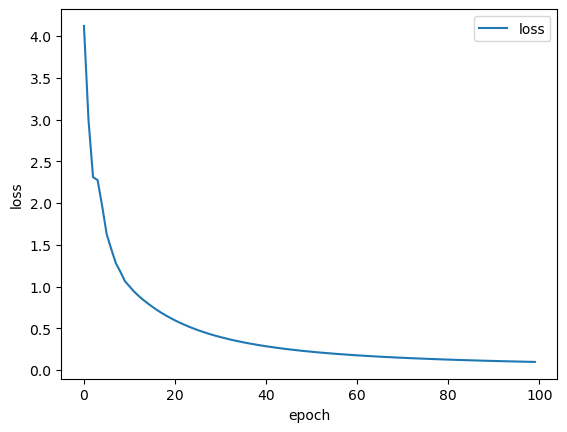

In [8]:
#更换优化器
iris_net4=IRIS_Net([4],'relu')
iris_net4=iris_net4.to(device)
iris_data=IRIS()
optimizer=optim.SGD(iris_net4.parameters(),0.01,0.9)
train(iris_net4,100,10,iris_data,optimizer)

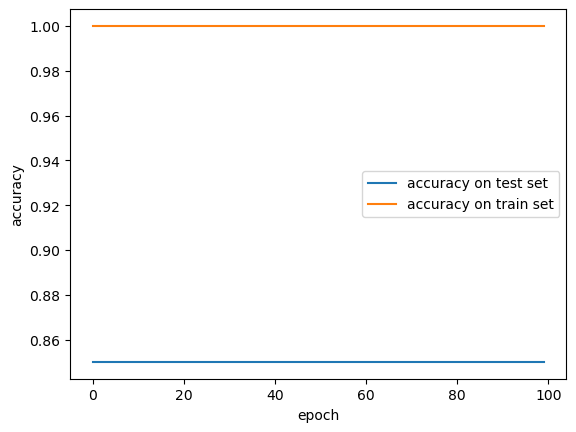

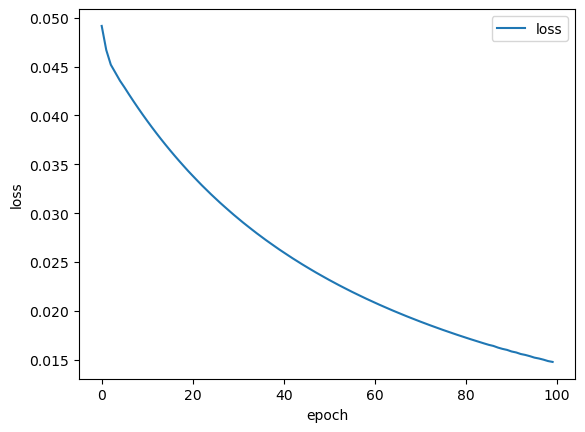

In [9]:
#更换激活函数
iris_net5=IRIS_Net([8,16,8],'tanh')
iris_net5=iris_net1.to(device)
iris_data=IRIS()
optimizer=optim.SGD(iris_net5.parameters(),0.01)
train(iris_net5,100,10,iris_data,optimizer)

In [10]:
#以下是mnist分类
#读取mnist数据集,直接从上一次的作业搬过来
import struct
class Mnist(Dataset):
    def __init__(self):
        self.train_set=self._get_img('实验数据集/MNIST/train-images-idx3-ubyte')
        self.test_set=self._get_img('实验数据集/MNIST/t10k-images-idx3-ubyte')
        self.train_label=self._get_label('实验数据集/MNIST/train-labels-idx1-ubyte')
        self.test_label=self._get_label('实验数据集/MNIST/t10k-labels-idx1-ubyte')
    
    def __len__(self):
        return self.train_set.shape[0]
    
    def _get_img(self, path):
        with open(path,'rb') as fi:
            ImgFile = fi.read()
            head = struct.unpack_from('>IIII', ImgFile, 0)
            #定位数据开始位置
            offset = struct.calcsize('>IIII')
            ImgNum = head[1]
            width = head[2]
            height = head[3]
            #每张图片包含的像素点
            pixel = height*width
            bits = ImgNum * width * height
            bitsString = '>' + str(bits) + 'B'
            #读取文件信息
            images = struct.unpack_from(bitsString, ImgFile, offset)
            #转化为n*726矩阵
            images = np.reshape(images,[ImgNum,pixel])
            images=torch.tensor(images).float()
            images=images.reshape((images.shape[0],1,28,28))
        return images

    def _get_label(self, path):

        with open(path,'rb') as fl:
            LableFile = fl.read()
            head = struct.unpack_from('>II', LableFile, 0)
            labelNum = head[1]
            #定位标签开始位置
            offset = struct.calcsize('>II')
            numString = '>' + str(labelNum) + "B"
            labels = struct.unpack_from(numString, LableFile, offset)
            #转化为1*n矩阵
            labels = np.reshape(labels, [labelNum]).reshape(1,-1)
            labels=torch.tensor(labels).int()

        return labels


    def __getitem__(self, index: int):
        return self.train_set[index], self.train_label[0,index]

In [11]:
#以下是Lenet
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        self.conv1=nn.Conv2d(1,6,5,1,2)
        self.ac1=nn.Sigmoid()
        self.av1pool=nn.AvgPool2d(2,2)
        self.conv2=nn.Conv2d(6,16,5,1,0)
        self.ac2=nn.Sigmoid()
        self.av2pool=nn.AvgPool2d(2,2)
        self.flatten=nn.Flatten()
        self.fc1 = nn.Linear(400,120)
        self.ac3=nn.Sigmoid()
        self.fc2 = nn.Linear(120,84)
        self.ac4=nn.Sigmoid()
        self.fc3=nn.Linear(84,10)
        self._initialize()
    def forward(self,x):
        conv1_out=self.ac1(self.conv1(x))
        pool1_out=self.av1pool(conv1_out)
        conv2_out=self.ac2(self.conv2(pool1_out))
        pool2_out=self.av2pool(conv2_out)
        flat=self.flatten(pool2_out)
        fc1_out=self.ac3(self.fc1(flat))
        fc2_out=self.ac4(self.fc2(fc1_out))
        logits=self.fc3(fc2_out)

        return logits

    def _initialize(self):#初始化权重
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)


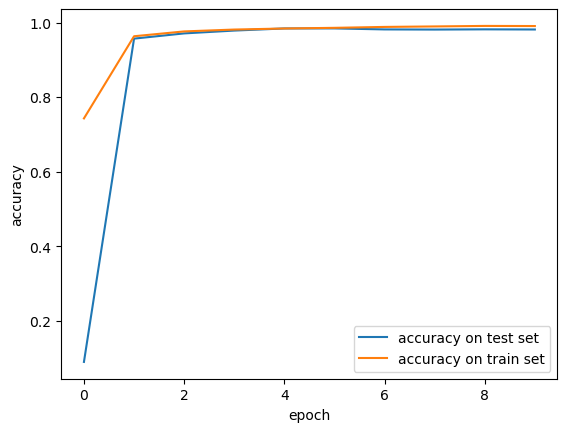

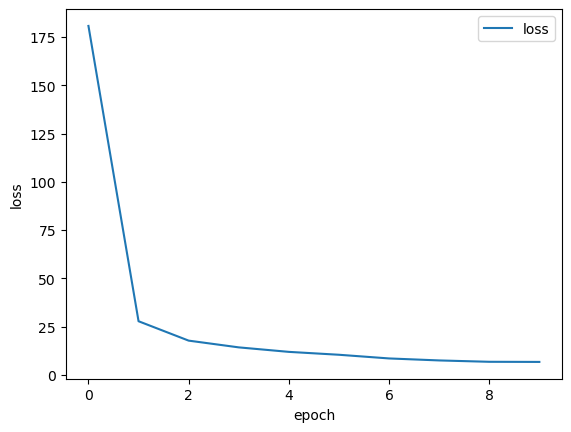

In [13]:
#下面跑网络
mnist_data=Mnist()
lenet=LeNet()
lenet=lenet.to(device)
optimizer=optim.Adam(lenet.parameters(),0.01,(0.9,0.9))
train(lenet,10,256,mnist_data,optimizer)

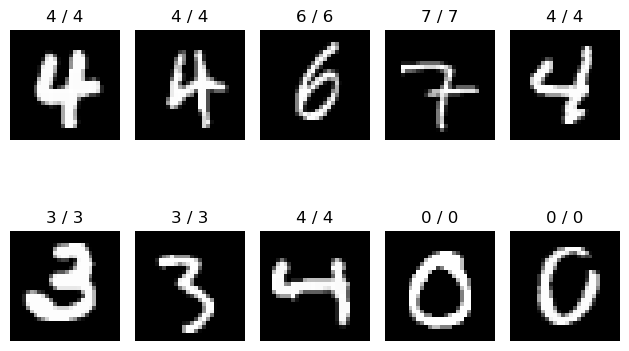

In [21]:
#抽十个展示
idx=np.random.choice(mnist_data.test_set.shape[0],10,False)
idx=torch.tensor(idx).long()
example=mnist_data.test_set[idx].to(device)
label=mnist_data.test_label[0,idx]
predict=lenet(example).cpu()
prediction=torch.argmax(predict,-1)
example=example.cpu()
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.title('%i / %i'%(prediction[i],label[i]))
    plt.imshow(np.squeeze(example[i]),cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()